In [1]:
import numpy as np
from pybaseball import statcast
from pybaseball import cache
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
cache.enable()

In [18]:
main_data = statcast("2018-04-02", "2020-12-31")

This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates
Skipping offseason dates


100%|██████████| 532/532 [00:23<00:00, 22.44it/s]


In [19]:
df = main_data

In [20]:
df = df.loc[df['description'].isin(['called_strike', 'ball'])]

In [21]:
df = df.loc[((df['plate_z'] <= df['sz_top']+(1/3)) & (df['plate_z'] >= df['sz_top']-(1/3)) & (df['plate_x'] >= -1.108) & (df['plate_x'] <= 1.108)) | ((df['plate_z'] <= df['sz_bot']+(1/3)) & (df['plate_z'] >= df['sz_bot']-(1/3)) & (df['plate_x'] >= -1.108) & (df['plate_x'] <= 1.108)) | ((df['plate_x'] >= -1.108) & (df['plate_x'] <= -0.558) & (df['plate_z'] <= df['sz_top']-(1/3)) & (df['plate_z'] >= df['sz_bot']+(1/3))) | ((df['plate_x'] <= 1.108) & (df['plate_x'] >= 0.558) & (df['plate_z'] <= df['sz_top']-(1/3)) & (df['plate_z'] >= df['sz_bot']+(1/3)))] 
df['description'].value_counts()

called_strike    183537
ball             147314
Name: description, dtype: int64

In [22]:
df = df[df.pitch_name != 'Forkball']
df = df[df.pitch_name != 'Screwball']
df['called_strike'] = np.where(df['description'] == "called_strike", 1, 0)

In [25]:
len(df.pitch_name.unique().tolist())

12

In [5]:
cols_to_use = ['sz_top', 'sz_bot', 'pitcher', 'batter', 'fielder_2', 'pitch_name', 'balls', 'strikes', 'release_pos_x', 'release_pos_z', 'release_speed', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'outs_when_up', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'effective_speed', 'release_spin_rate', 'release_extension', 'release_pos_y', 'zone', 'p_throws', 'stand', 'pitch_number', 'spin_axis', 'called_strike']

In [8]:
df = df[cols_to_use]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 330837 entries, 95 to 3489
Data columns (total 32 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   sz_top             330837 non-null  Float64
 1   sz_bot             330837 non-null  Float64
 2   pitcher            330837 non-null  Int64  
 3   batter             330837 non-null  Int64  
 4   fielder_2          330837 non-null  Int64  
 5   pitch_name         330797 non-null  object 
 6   balls              330837 non-null  Int64  
 7   strikes            330837 non-null  Int64  
 8   release_pos_x      330837 non-null  Float64
 9   release_pos_z      330837 non-null  Float64
 10  release_speed      330835 non-null  Float64
 11  pfx_x              330837 non-null  Float64
 12  pfx_z              330837 non-null  Float64
 13  plate_x            330837 non-null  Float64
 14  plate_z            330837 non-null  Float64
 15  outs_when_up       330837 non-null  Int64  
 16  vx0

In [9]:
df = df.dropna()

In [10]:
X = df.drop(['sz_top', 'sz_bot', 'pitcher', 'fielder_2', 'called_strike', 'batter'], 1)
y = df.called_strike

/var/folders/w3/7q3wzvhj48n9gsxkkfks4zq00000gn/T/ipykernel_73821/380996901.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = df.drop(['sz_top', 'sz_bot', 'pitcher', 'fielder_2', 'called_strike', 'batter'], 1)


In [11]:
X = pd.get_dummies(X, columns=['pitch_name', 'balls', 'strikes', 'outs_when_up', 'zone', 'p_throws', 'stand'])
feature_names = X.columns.tolist()
print(feature_names)
X.to_csv('X.csv', index=False)
X = pd.read_csv('X.csv')
X.info()

['release_pos_x', 'release_pos_z', 'release_speed', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'effective_speed', 'release_spin_rate', 'release_extension', 'release_pos_y', 'pitch_number', 'spin_axis', 'pitch_name_4-Seam Fastball', 'pitch_name_Changeup', 'pitch_name_Curveball', 'pitch_name_Cutter', 'pitch_name_Eephus', 'pitch_name_Fastball', 'pitch_name_Knuckle Curve', 'pitch_name_Knuckleball', 'pitch_name_Sinker', 'pitch_name_Slider', 'pitch_name_Split-Finger', 'balls_0', 'balls_1', 'balls_2', 'balls_3', 'strikes_0', 'strikes_1', 'strikes_2', 'outs_when_up_0', 'outs_when_up_1', 'outs_when_up_2', 'zone_1', 'zone_2', 'zone_3', 'zone_4', 'zone_6', 'zone_7', 'zone_8', 'zone_9', 'zone_11', 'zone_12', 'zone_13', 'zone_14', 'p_throws_L', 'p_throws_R', 'stand_L', 'stand_R']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326879 entries, 0 to 326878
Data columns (total 56 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------      

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 1011)

In [13]:
import xgboost as xgb

xgb_cl = xgb.XGBClassifier(use_label_encoder=False)
xgb_cl.fit(X_train, y_train)

/Users/simonmiller/opt/anaconda3/envs/pbb/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/simonmiller/opt/anaconda3/envs/pbb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:47:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [14]:
from sklearn.metrics import accuracy_score

preds = xgb_cl.predict(X_test)
accuracy_score(y_test, preds)

0.8329968184043074

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "max_depth": [3, 4, 5, 7],
    "learning_rate": [0.1, 0.01, 0.05],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0, 1, 10],
    "scale_pos_weight": [1, 3, 5],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
}

xgb_cl = xgb.XGBClassifier(objective="binary:logistic")

grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=3, scoring="roc_auc")

_ = grid_cv.fit(X_train, y_train)

In [19]:
grid_cv.best_score_

0.9144186910097796

In [20]:
grid_cv.best_params_

{'colsample_bytree': 0.5,
 'gamma': 1,
 'learning_rate': 0.1,
 'max_depth': 7,
 'reg_lambda': 10,
 'scale_pos_weight': 1,
 'subsample': 0.8}

In [15]:
best_params = {'colsample_bytree': 0.5,
 'gamma': 1,
 'learning_rate': 0.1,
 'max_depth': 7,
 'reg_lambda': 10,
 'scale_pos_weight': 1,
 'subsample': 0.8}

final_cl = xgb.XGBClassifier(
    params = best_params,
    objective='binary:logistic'
)

In [16]:
_ = final_cl.fit(X_train, y_train)

/Users/simonmiller/opt/anaconda3/envs/pbb/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/simonmiller/opt/anaconda3/envs/pbb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:48:09] WARNING: ../src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:48:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [17]:
final_preds = final_cl.predict(X_test)
accuracy_score(y_test, final_preds)

0.8329968184043074

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

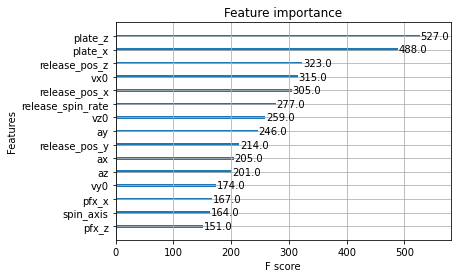

In [18]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plot_importance(final_cl, max_num_features=15)

In [19]:
df_2021 = statcast('2021-04-02', '2021-12-31')

This is a large query, it may take a moment to complete
Skipping offseason dates


100%|██████████| 228/228 [00:05<00:00, 44.60it/s]


In [3]:
from pybaseball import chadwick_register

players = chadwick_register()
players['full_name'] = players['name_first'] + ' ' + players['name_last']
players.head()

,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last,full_name
0,Aardsma,David,430911,aardd001,aardsda01,1902,2004.0,2015.0,David Aardsma
1,Aaron,Hank,110001,aaroh101,aaronha01,1000001,1954.0,1976.0,Hank Aaron
2,Aaron,Tommie,110002,aarot101,aaronto01,1000002,1962.0,1971.0,Tommie Aaron
3,Aase,Don,110003,aased001,aasedo01,1000003,1977.0,1990.0,Don Aase
4,Abad,Andy,407577,abada001,abadan01,506,2001.0,2006.0,Andy Abad


In [21]:
df_2021 = df_2021.loc[df_2021['description'].isin(['called_strike', 'ball'])]
df_2021 = df_2021.loc[((df_2021['plate_z'] <= df_2021['sz_top']+(1/3)) & (df_2021['plate_z'] >= df_2021['sz_top']-(1/3)) & (df_2021['plate_x'] >= -1.108) & (df_2021['plate_x'] <= 1.108)) | ((df_2021['plate_z'] <= df_2021['sz_bot']+(1/3)) & (df_2021['plate_z'] >= df_2021['sz_bot']-(1/3)) & (df_2021['plate_x'] >= -1.108) & (df_2021['plate_x'] <= 1.108)) | ((df_2021['plate_x'] >= -1.108) & (df_2021['plate_x'] <= -0.558) & (df_2021['plate_z'] <= df_2021['sz_top']-(1/3)) & (df_2021['plate_z'] >= df_2021['sz_bot']+(1/3))) | ((df_2021['plate_x'] <= 1.108) & (df_2021['plate_x'] >= 0.558) & (df_2021['plate_z'] <= df_2021['sz_top']-(1/3)) & (df_2021['plate_z'] >= df_2021['sz_bot']+(1/3)))] 
df_2021['called_strike'] = np.where(df_2021['description'] == "called_strike", 1, 0)
df_2021 = df_2021[cols_to_use]
df_2021 = df_2021.dropna()


In [22]:
df_2021 = df_2021.merge(players[['key_mlbam', 'full_name']], left_on='fielder_2', right_on='key_mlbam')
df_2021 = df_2021.drop(['key_mlbam'], 1)
df_2021 = df_2021.rename(columns={'full_name' : 'catcher_name'})
df_2021 = df_2021.merge(players[['key_mlbam', 'full_name']], left_on='pitcher', right_on='key_mlbam')
df_2021 = df_2021.drop(['key_mlbam'], 1)
df_2021 = df_2021.rename(columns={'full_name' : 'pitcher_name'})
df_2021 = df_2021.merge(players[['key_mlbam', 'full_name']], left_on='batter', right_on='key_mlbam')
df_2021 = df_2021.drop(['key_mlbam'], 1)
df_2021 = df_2021.rename(columns={'full_name' : 'batter_name'})
df_2021.head()

/var/folders/w3/7q3wzvhj48n9gsxkkfks4zq00000gn/T/ipykernel_73821/771061896.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_2021 = df_2021.drop(['key_mlbam'], 1)
/var/folders/w3/7q3wzvhj48n9gsxkkfks4zq00000gn/T/ipykernel_73821/771061896.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_2021 = df_2021.drop(['key_mlbam'], 1)
/var/folders/w3/7q3wzvhj48n9gsxkkfks4zq00000gn/T/ipykernel_73821/771061896.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_2021 = df_2021.drop(['key_mlbam'], 1)


,sz_top,sz_bot,pitcher,batter,fielder_2,pitch_name,balls,strikes,release_pos_x,release_pos_z,release_speed,pfx_x,pfx_z,plate_x,plate_z,outs_when_up,vx0,vy0,vz0,ax,ay,az,effective_speed,release_spin_rate,release_extension,release_pos_y,zone,p_throws,stand,pitch_number,spin_axis,called_strike,catcher_name,pitcher_name,batter_name
0,3.4,1.53,519293,493329,518595,4-Seam Fastball,0,0,1.35,6.73,93.1,0.81,1.52,0.78,2.13,2,-3.230974,-135.201801,-9.255781,10.67848,31.699974,-11.7058,92.5,2216,6.2,54.3,6,L,R,1,143,1,Travis d'Arnaud,Will Smith,Yuli Gurriel
1,3.72,1.75,554431,493329,518595,4-Seam Fastball,0,0,1.84,6.31,96.3,0.22,1.54,-0.08,3.85,2,-5.594259,-140.120425,-4.402959,4.172471,33.466024,-11.180782,96.2,2143,6.3,54.16,11,L,R,1,151,0,Travis d'Arnaud,Tyler Matzek,Yuli Gurriel
2,3.25,1.53,608331,493329,518595,4-Seam Fastball,0,2,1.16,6.12,98.4,0.28,1.19,-0.31,1.63,2,-4.644087,-143.019557,-9.492362,4.868018,32.177615,-13.819769,98.6,2226,6.4,54.07,7,L,R,3,161,1,Travis d'Arnaud,Max Fried,Yuli Gurriel
3,3.28,1.53,608331,493329,518595,4-Seam Fastball,0,0,1.27,6.03,97.3,0.49,1.3,-0.06,1.64,2,-4.69023,-141.470306,-9.255366,7.661681,30.601169,-12.87361,97.6,2178,6.4,54.09,8,L,R,1,149,1,Travis d'Arnaud,Max Fried,Yuli Gurriel
4,3.31,1.53,608331,493329,518595,Curveball,1,0,1.77,5.9,72.0,-0.68,-1.37,-0.19,1.63,0,-2.709603,-104.815032,1.375516,-4.486642,19.805334,-42.659501,71.4,2559,6.1,54.43,8,L,R,2,325,1,Travis d'Arnaud,Max Fried,Yuli Gurriel


In [23]:
df_2021['y'] = df_2021['plate_z'] - ((df_2021['sz_top'] + df_2021['sz_bot']) / 2)

In [26]:
X_2021 = df_2021.drop(['pitcher', 'batter', 'fielder_2', 'called_strike', 'sz_top', 'sz_bot', 'catcher_name', 'pitcher_name', 'batter_name', 'y'], 1)
X_2021 = pd.get_dummies(X_2021, columns=['pitch_name', 'balls', 'strikes', 'outs_when_up', 'zone', 'p_throws', 'stand'])
print(X_2021.columns.tolist())
X_2021 = X_2021.to_numpy()

['release_pos_x', 'release_pos_z', 'release_speed', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'effective_speed', 'release_spin_rate', 'release_extension', 'release_pos_y', 'pitch_number', 'spin_axis', 'pitch_name_4-Seam Fastball', 'pitch_name_Changeup', 'pitch_name_Curveball', 'pitch_name_Cutter', 'pitch_name_Eephus', 'pitch_name_Fastball', 'pitch_name_Knuckle Curve', 'pitch_name_Knuckleball', 'pitch_name_Sinker', 'pitch_name_Slider', 'pitch_name_Split-Finger', 'balls_0', 'balls_1', 'balls_2', 'balls_3', 'strikes_0', 'strikes_1', 'strikes_2', 'outs_when_up_0', 'outs_when_up_1', 'outs_when_up_2', 'zone_1', 'zone_2', 'zone_3', 'zone_4', 'zone_6', 'zone_7', 'zone_8', 'zone_9', 'zone_11', 'zone_12', 'zone_13', 'zone_14', 'p_throws_L', 'p_throws_R', 'stand_L', 'stand_R']


/var/folders/w3/7q3wzvhj48n9gsxkkfks4zq00000gn/T/ipykernel_73821/2743531434.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_2021 = df_2021.drop(['pitcher', 'batter', 'fielder_2', 'called_strike', 'sz_top', 'sz_bot', 'catcher_name', 'pitcher_name', 'batter_name', 'y'], 1)


In [27]:
y_pred_2021 = final_cl.predict_proba(X_2021)
y_pred_2021 = y_pred_2021.tolist()
y_pred_2021 = [l[1] for l in y_pred_2021]

In [28]:
df_2021['strike_proba'] = y_pred_2021
df_2021.head()

,sz_top,sz_bot,pitcher,batter,fielder_2,pitch_name,balls,strikes,release_pos_x,release_pos_z,release_speed,pfx_x,pfx_z,plate_x,plate_z,outs_when_up,vx0,vy0,vz0,ax,ay,az,effective_speed,release_spin_rate,release_extension,release_pos_y,zone,p_throws,stand,pitch_number,spin_axis,called_strike,catcher_name,pitcher_name,batter_name,y,strike_proba
0,3.4,1.53,519293,493329,518595,4-Seam Fastball,0,0,1.35,6.73,93.1,0.81,1.52,0.78,2.13,2,-3.230974,-135.201801,-9.255781,10.67848,31.699974,-11.7058,92.5,2216,6.2,54.3,6,L,R,1,143,1,Travis d'Arnaud,Will Smith,Yuli Gurriel,-0.335,0.927985
1,3.72,1.75,554431,493329,518595,4-Seam Fastball,0,0,1.84,6.31,96.3,0.22,1.54,-0.08,3.85,2,-5.594259,-140.120425,-4.402959,4.172471,33.466024,-11.180782,96.2,2143,6.3,54.16,11,L,R,1,151,0,Travis d'Arnaud,Tyler Matzek,Yuli Gurriel,1.115,0.002287
2,3.25,1.53,608331,493329,518595,4-Seam Fastball,0,2,1.16,6.12,98.4,0.28,1.19,-0.31,1.63,2,-4.644087,-143.019557,-9.492362,4.868018,32.177615,-13.819769,98.6,2226,6.4,54.07,7,L,R,3,161,1,Travis d'Arnaud,Max Fried,Yuli Gurriel,-0.76,0.714883
3,3.28,1.53,608331,493329,518595,4-Seam Fastball,0,0,1.27,6.03,97.3,0.49,1.3,-0.06,1.64,2,-4.69023,-141.470306,-9.255366,7.661681,30.601169,-12.87361,97.6,2178,6.4,54.09,8,L,R,1,149,1,Travis d'Arnaud,Max Fried,Yuli Gurriel,-0.765,0.878549
4,3.31,1.53,608331,493329,518595,Curveball,1,0,1.77,5.9,72.0,-0.68,-1.37,-0.19,1.63,0,-2.709603,-104.815032,1.375516,-4.486642,19.805334,-42.659501,71.4,2559,6.1,54.43,8,L,R,2,325,1,Travis d'Arnaud,Max Fried,Yuli Gurriel,-0.79,0.925410


In [29]:
catchers_df = df_2021[['catcher_name', 'fielder_2', 'pitch_number', 'called_strike', 'strike_proba']].groupby(['catcher_name', 'fielder_2']).agg({'pitch_number' : 'count', 'called_strike' : 'sum', 'strike_proba' : 'sum'}).reset_index()
catchers_df['total_strikes_OE'] = catchers_df['called_strike'] - catchers_df['strike_proba']
catchers_df['strike_rate'] = catchers_df['called_strike'] / catchers_df['pitch_number']
catchers_df['expected_strike_rate'] = catchers_df['strike_proba'] / catchers_df['pitch_number']
catchers_df['strike_rate_OE'] = catchers_df['strike_rate'] - catchers_df['expected_strike_rate']
catchers_df = catchers_df.sort_values('strike_rate_OE', ascending=False)
catchers_df[catchers_df['pitch_number'] > 300].head()

,catcher_name,fielder_2,pitch_number,called_strike,strike_proba,total_strikes_OE,strike_rate,expected_strike_rate,strike_rate_OE
96,Tomás Nido,621512,1100,673,615.665650,57.334350,0.611818,0.559696,0.052122
54,Jose Trevino,624431,2242,1343,1236.047100,106.952900,0.599019,0.551314,0.047704
60,Kyle Higashioka,543309,1553,903,835.361318,67.638682,0.581455,0.537902,0.043554
66,Max Stassi,545358,2252,1314,1216.315743,97.684257,0.583481,0.540105,0.043377
18,Cam Gallagher,595956,986,572,531.180477,40.819523,0.580122,0.538723,0.041399


In [30]:
pitchers_df = df_2021[['pitcher_name', 'pitcher', 'pitch_number', 'called_strike', 'strike_proba']].groupby(['pitcher_name', 'pitcher']).agg({'pitch_number' : 'count', 'called_strike' : 'sum', 'strike_proba' : 'sum'}).reset_index()
pitchers_df['total_strikes_OE'] = pitchers_df['called_strike'] - pitchers_df['strike_proba']
pitchers_df['strike_rate'] = pitchers_df['called_strike'] / pitchers_df['pitch_number']
pitchers_df['expected_strike_rate'] = pitchers_df['strike_proba'] / pitchers_df['pitch_number']
pitchers_df['strike_rate_OE'] = pitchers_df['strike_rate'] - pitchers_df['expected_strike_rate']
pitchers_df = pitchers_df.sort_values('strike_rate_OE', ascending=False)
pitchers_df[pitchers_df['pitch_number'] > 200].head(20)

,pitcher_name,pitcher,pitch_number,called_strike,strike_proba,total_strikes_OE,strike_rate,expected_strike_rate,strike_rate_OE
367,Jacob deGrom,594798,201,127,101.088319,25.911681,0.631841,0.502927,0.128914
865,Wade Miley,489119,452,288,245.967783,42.032217,0.637168,0.544177,0.092992
512,Kendall Graveman,608665,201,118,100.092295,17.907705,0.587065,0.497972,0.089093
93,Bailey Ober,641927,260,160,137.038183,22.961817,0.615385,0.527070,0.088315
616,Michael Pineda,501381,320,209,181.600182,27.399818,0.653125,0.567501,0.085624
103,Brad Boxberger,502202,213,125,107.380725,17.619275,0.586854,0.504135,0.082720
359,JT Brubaker,664141,364,209,183.353886,25.646114,0.574176,0.503719,0.070456
540,Kyle Gibson,502043,567,344,310.295227,33.704773,0.606702,0.547258,0.059444
386,James Kaprielian,621076,378,241,218.552995,22.447005,0.637566,0.578183,0.059384
19,Adam Ottavino,493603,242,155,140.876534,14.123466,0.640496,0.582134,0.058361


In [31]:
batters_df = df_2021[['batter_name', 'batter', 'pitch_number', 'called_strike', 'strike_proba']].groupby(['batter_name', 'batter']).agg({'pitch_number' : 'count', 'called_strike' : 'sum', 'strike_proba' : 'sum'}).reset_index()
batters_df['total_strikes_OE'] = batters_df['called_strike'] - batters_df['strike_proba']
batters_df['strike_rate'] = batters_df['called_strike'] / batters_df['pitch_number']
batters_df['expected_strike_rate'] = batters_df['strike_proba'] / batters_df['pitch_number']
batters_df['strike_rate_OE'] = batters_df['strike_rate'] - batters_df['expected_strike_rate']
batters_df = batters_df.sort_values('strike_rate_OE', ascending=False)
batters_df[batters_df['pitch_number'] > 150].head(20)

,batter_name,batter,pitch_number,called_strike,strike_proba,total_strikes_OE,strike_rate,expected_strike_rate,strike_rate_OE
250,Donovan Solano,456781,221,145,126.361341,18.638659,0.656109,0.571771,0.084338
987,Zach McKinstry,656716,154,98,86.095009,11.904991,0.636364,0.559059,0.077305
933,Tyrone Taylor,621438,178,113,99.776713,13.223287,0.634831,0.560543,0.074288
747,Philip Gosselin,594838,304,207,184.802928,22.197072,0.680921,0.607904,0.073017
471,Jonah Heim,641680,203,124,109.355367,14.644633,0.610837,0.538696,0.072141
29,Aledmys Díaz,649557,199,126,112.476943,13.523057,0.633166,0.565211,0.067955
108,Brandon Marsh,669016,203,120,106.655341,13.344659,0.591133,0.525396,0.065737
103,Bradley Zimmer,605548,282,161,143.915465,17.084535,0.570922,0.510339,0.060583
454,Joey Wendle,621563,360,227,205.787344,21.212656,0.630556,0.571632,0.058924
735,Patrick Wisdom,621550,274,144,127.871295,16.128705,0.525547,0.466684,0.058864


In [54]:
import plotly.graph_objects as go

fig = go.Figure()

df_current = df_2021[df_2021['batter'] == 488726]
avg_top = df_current.sz_top.mean()
avg_bot = df_current.sz_bot.mean()
mid = (avg_top + avg_bot) / 2
print(avg_top)
print(avg_bot)
print(mid)

from PIL import Image
import requests
from io import BytesIO

resp = requests.get('https://img.mlbstatic.com/mlb-photos/image/upload/q_100/v1/people/488726/headshot/67/current')
img = Image.open(BytesIO(resp.content))

fig.add_trace(
    go.Scatter(
        x = df_current[df_current['called_strike'] == 1].plate_x,
        y = df_current[df_current['called_strike'] == 1].y,
        mode = 'markers',
        name = 'Called Strike',
        marker=dict(
            color = 'black',
            size = df_current[df_current['called_strike'] == 1].strike_proba * 10 + 2
        )
    )
)

fig.add_trace(
    go.Scatter(
        x = df_current[df_current['called_strike'] == 0].plate_x,
        y = df_current[df_current['called_strike'] == 0].y,
        mode = 'markers',
        name = 'Ball',
        marker=dict(
            color = 'red',
            size = df_current[df_current['called_strike'] == 0].strike_proba * 10 + 2
        )
    )
)

fig.add_layout_image(dict(
        source=img,
        xref="paper", yref="paper",
        x=-0.2, y=0.5,
        sizex=0.2, sizey=0.2,
        xanchor="right", yanchor="bottom"
    ))


fig.add_shape(type='rect', x0=-0.83333, x1=0.83333, y0=avg_bot-mid, y1=avg_top-mid, line=dict(color='black'))

fig.update_layout(
    height=1000,
    width=1000,
    margin=dict(r=20, l=300, b=75, t=125),
    title = "Shadow Zone Pitches for Michael Brantly"
)

3.318147268408551
1.5376247030878858
2.4278859857482185


In [56]:
df_2021.to_csv('data_2021.csv', index=False)

In [57]:
import pickle
pickle.dump(final_cl, open('SCOE_model.sav', 'wb'))

In [2]:
df_2022 = statcast('2022-04-01', '2022-08-01')

This is a large query, it may take a moment to complete


100%|██████████| 123/123 [00:08<00:00, 13.71it/s]


In [6]:
df_2022 = df_2022.loc[df_2022['description'].isin(['called_strike', 'ball'])]
df_2022 = df_2022.loc[((df_2022['plate_z'] <= df_2022['sz_top']+(1/3)) & (df_2022['plate_z'] >= df_2022['sz_top']-(1/3)) & (df_2022['plate_x'] >= -1.108) & (df_2022['plate_x'] <= 1.108)) | ((df_2022['plate_z'] <= df_2022['sz_bot']+(1/3)) & (df_2022['plate_z'] >= df_2022['sz_bot']-(1/3)) & (df_2022['plate_x'] >= -1.108) & (df_2022['plate_x'] <= 1.108)) | ((df_2022['plate_x'] >= -1.108) & (df_2022['plate_x'] <= -0.558) & (df_2022['plate_z'] <= df_2022['sz_top']-(1/3)) & (df_2022['plate_z'] >= df_2022['sz_bot']+(1/3))) | ((df_2022['plate_x'] <= 1.108) & (df_2022['plate_x'] >= 0.558) & (df_2022['plate_z'] <= df_2022['sz_top']-(1/3)) & (df_2022['plate_z'] >= df_2022['sz_bot']+(1/3)))] 
df_2022['called_strike'] = np.where(df_2022['description'] == "called_strike", 1, 0)
df_2022 = df_2022[cols_to_use]
df_2022 = df_2022.dropna()

In [7]:
df_2022 = df_2022.merge(players[['key_mlbam', 'full_name']], left_on='fielder_2', right_on='key_mlbam')
df_2022 = df_2022.drop(['key_mlbam'], 1)
df_2022 = df_2022.rename(columns={'full_name' : 'catcher_name'})
df_2022 = df_2022.merge(players[['key_mlbam', 'full_name']], left_on='pitcher', right_on='key_mlbam')
df_2022 = df_2022.drop(['key_mlbam'], 1)
df_2022 = df_2022.rename(columns={'full_name' : 'pitcher_name'})
df_2022 = df_2022.merge(players[['key_mlbam', 'full_name']], left_on='batter', right_on='key_mlbam')
df_2022 = df_2022.drop(['key_mlbam'], 1)
df_2022 = df_2022.rename(columns={'full_name' : 'batter_name'})
df_2022.head()

/var/folders/w3/7q3wzvhj48n9gsxkkfks4zq00000gn/T/ipykernel_34734/3222201529.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_2022 = df_2022.drop(['key_mlbam'], 1)
/var/folders/w3/7q3wzvhj48n9gsxkkfks4zq00000gn/T/ipykernel_34734/3222201529.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_2022 = df_2022.drop(['key_mlbam'], 1)
/var/folders/w3/7q3wzvhj48n9gsxkkfks4zq00000gn/T/ipykernel_34734/3222201529.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_2022 = df_2022.drop(['key_mlbam'], 1)


,sz_top,sz_bot,pitcher,batter,fielder_2,pitch_name,balls,strikes,release_pos_x,release_pos_z,release_speed,pfx_x,pfx_z,plate_x,plate_z,outs_when_up,vx0,vy0,vz0,ax,ay,az,effective_speed,release_spin_rate,release_extension,release_pos_y,zone,p_throws,stand,pitch_number,spin_axis,called_strike,catcher_name,pitcher_name,batter_name
0,3.27,1.42,453343,680757,608348,Cutter,2,1,-3.08,6.28,91.1,-0.39,0.94,-0.98,2.58,2,6.115245,-132.547194,-5.472638,-5.795415,25.35041,-20.11928,91.6,2378,6.4,54.12,11,R,L,4,191,0,Carson Kelly,Mark Melancon,Steven Kwan
1,3.27,1.53,453343,680757,608348,Knuckle Curve,1,0,-2.77,6.3,81.5,0.43,-1.02,-0.72,1.8,2,3.778222,-118.648816,-1.509054,3.244271,24.135545,-41.708522,80.9,2521,6.0,54.48,7,R,L,2,20,1,Carson Kelly,Mark Melancon,Steven Kwan
2,3.27,1.44,453343,680757,608348,Knuckle Curve,0,0,-2.77,6.45,81.7,0.33,-1.07,-1.09,2.46,2,3.120699,-118.975457,-0.359848,2.58972,22.609885,-42.473433,81.6,2542,6.2,54.34,11,R,L,1,15,0,Carson Kelly,Mark Melancon,Steven Kwan
3,2.91,1.46,453178,680757,608348,Knuckle Curve,0,0,-1.47,5.59,77.6,0.53,-0.62,-0.06,2.89,1,2.039414,-113.126599,2.14784,4.320041,17.255607,-38.10439,78.2,2527,6.2,54.28,2,R,L,1,41,1,Carson Kelly,Ian Kennedy,Steven Kwan
4,3.38,1.44,598287,680757,608348,4-Seam Fastball,0,0,-2.68,4.69,89.5,-1.18,0.68,-0.9,2.6,1,6.810318,-130.320815,-0.645009,-14.820052,25.625689,-24.469475,89.1,2149,5.8,54.67,11,R,L,1,242,1,Carson Kelly,Noe Ramirez,Steven Kwan


In [9]:
X_2022 = df_2022.drop(['pitcher', 'batter', 'fielder_2', 'called_strike', 'sz_top', 'sz_bot', 'catcher_name', 'pitcher_name', 'batter_name'], 1)
X_2022 = pd.get_dummies(X_2022, columns=['pitch_name', 'balls', 'strikes', 'outs_when_up', 'zone', 'p_throws', 'stand'])
print(X_2022.columns.tolist())
X_2022.to_csv('X_2022.csv', index=False)
X_2022 = pd.read_csv('X_2022.csv')

/var/folders/w3/7q3wzvhj48n9gsxkkfks4zq00000gn/T/ipykernel_34734/2895957624.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_2022 = df_2022.drop(['pitcher', 'batter', 'fielder_2', 'called_strike', 'sz_top', 'sz_bot', 'catcher_name', 'pitcher_name', 'batter_name'], 1)


['release_pos_x', 'release_pos_z', 'release_speed', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'effective_speed', 'release_spin_rate', 'release_extension', 'release_pos_y', 'pitch_number', 'spin_axis', 'pitch_name_4-Seam Fastball', 'pitch_name_Changeup', 'pitch_name_Curveball', 'pitch_name_Cutter', 'pitch_name_Eephus', 'pitch_name_Fastball', 'pitch_name_Knuckle Curve', 'pitch_name_Knuckleball', 'pitch_name_Sinker', 'pitch_name_Slider', 'pitch_name_Split-Finger', 'balls_0', 'balls_1', 'balls_2', 'balls_3', 'strikes_0', 'strikes_1', 'strikes_2', 'outs_when_up_0', 'outs_when_up_1', 'outs_when_up_2', 'zone_1', 'zone_2', 'zone_3', 'zone_4', 'zone_6', 'zone_7', 'zone_8', 'zone_9', 'zone_11', 'zone_12', 'zone_13', 'zone_14', 'p_throws_L', 'p_throws_R', 'stand_L', 'stand_R']


In [26]:
import pickle

cl = pickle.load(open('SCOE_model.sav', 'rb'))

In [11]:
y_pred_2022 = cl.predict_proba(X_2022)
y_pred_2022 = y_pred_2022.tolist()
y_pred_2022 = [l[1] for l in y_pred_2022]

In [16]:
df_2022['strike_proba'] = y_pred_2022
df_2022.head()

,sz_top,sz_bot,pitcher,batter,fielder_2,pitch_name,balls,strikes,release_pos_x,release_pos_z,release_speed,pfx_x,pfx_z,plate_x,plate_z,outs_when_up,vx0,vy0,vz0,ax,ay,az,effective_speed,release_spin_rate,release_extension,release_pos_y,zone,p_throws,stand,pitch_number,spin_axis,called_strike,catcher_name,pitcher_name,batter_name,strike_proba
0,3.27,1.42,453343,680757,608348,Cutter,2,1,-3.08,6.28,91.1,-0.39,0.94,-0.98,2.58,2,6.115245,-132.547194,-5.472638,-5.795415,25.35041,-20.11928,91.6,2378,6.4,54.12,11,R,L,4,191,0,Carson Kelly,Mark Melancon,Steven Kwan,0.699234
1,3.27,1.53,453343,680757,608348,Knuckle Curve,1,0,-2.77,6.3,81.5,0.43,-1.02,-0.72,1.8,2,3.778222,-118.648816,-1.509054,3.244271,24.135545,-41.708522,80.9,2521,6.0,54.48,7,R,L,2,20,1,Carson Kelly,Mark Melancon,Steven Kwan,0.954141
2,3.27,1.44,453343,680757,608348,Knuckle Curve,0,0,-2.77,6.45,81.7,0.33,-1.07,-1.09,2.46,2,3.120699,-118.975457,-0.359848,2.58972,22.609885,-42.473433,81.6,2542,6.2,54.34,11,R,L,1,15,0,Carson Kelly,Mark Melancon,Steven Kwan,0.263597
3,2.91,1.46,453178,680757,608348,Knuckle Curve,0,0,-1.47,5.59,77.6,0.53,-0.62,-0.06,2.89,1,2.039414,-113.126599,2.14784,4.320041,17.255607,-38.10439,78.2,2527,6.2,54.28,2,R,L,1,41,1,Carson Kelly,Ian Kennedy,Steven Kwan,0.993821
4,3.38,1.44,598287,680757,608348,4-Seam Fastball,0,0,-2.68,4.69,89.5,-1.18,0.68,-0.9,2.6,1,6.810318,-130.320815,-0.645009,-14.820052,25.625689,-24.469475,89.1,2149,5.8,54.67,11,R,L,1,242,1,Carson Kelly,Noe Ramirez,Steven Kwan,0.793046


In [17]:
df_2022.to_csv('data/shadow_zone_data_2022.csv', index=False)